#Netflix Content Clustering & Recommendation Using Unsupervised Learning

` DS/AI/ML Project`

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
from sklearn.manifold import TSNE

In [3]:
df=pd.read_csv("NetflixSimple.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#Data Exploration
Data will be cleaned/prepped/preprocessed for the model...

In [4]:
print(df.info(),'\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB
None 

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description   

In [5]:
# Checking the data distribution...
print(df['type'].value_counts(),"\n")
print(df['country'].value_counts().head(10),'\n')
print(df['rating'].value_counts())
pd.crosstab(df['rating'], df['type'])

type
Movie      5377
TV Show    2410
Name: count, dtype: int64 

country
United States     2555
India              923
United Kingdom     397
Japan              226
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Turkey             100
Name: count, dtype: int64 

rating
TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: count, dtype: int64


type,Movie,TV Show
rating,,
G,39,0
NC-17,3,0
NR,79,5
PG,247,0
PG-13,386,0
R,663,2
TV-14,1272,659
TV-G,111,83
TV-MA,1845,1018


### Content Type Distribution

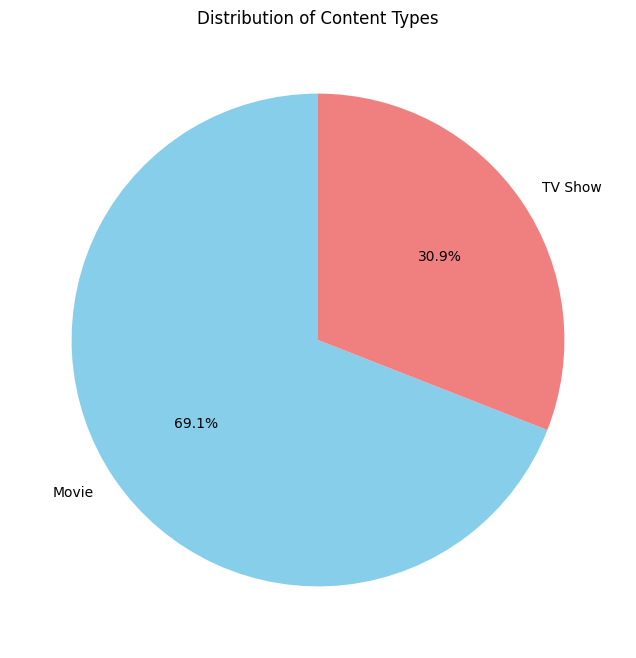

In [6]:
plt.figure(figsize=(8, 8))
df['type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Content Types')
plt.ylabel('') # Hide the default label
plt.show()

### Top 10 Countries with Content

In [7]:
#Handling Country Missing Values
df['country'] = df['country'].fillna('Unknown')
countries = df['country'].str.split(', ').explode()

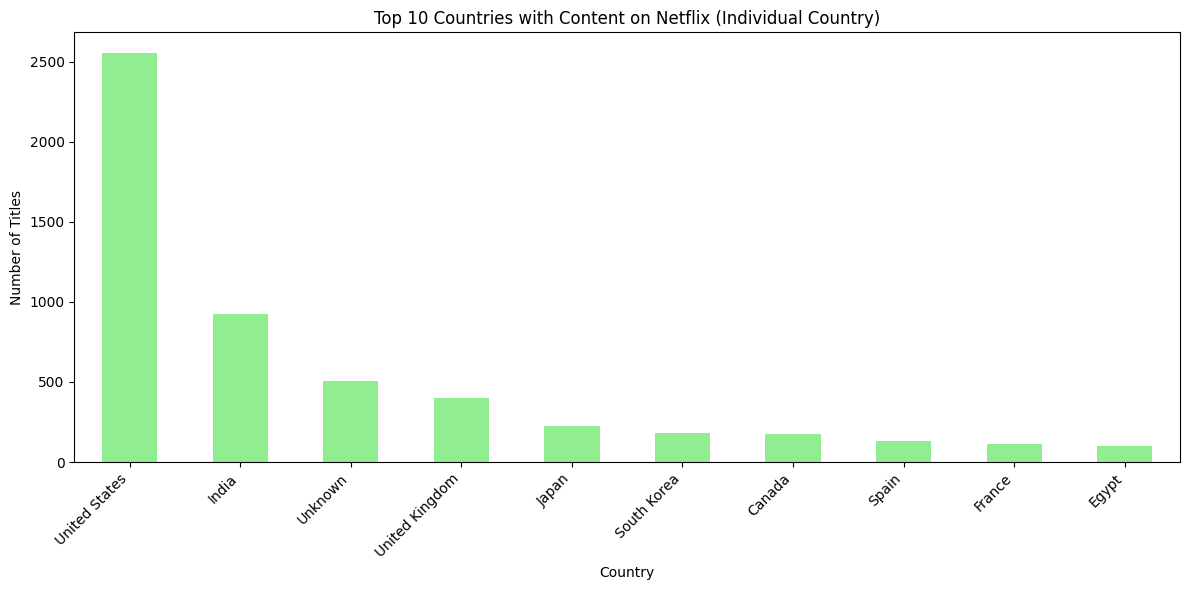

In [8]:
plt.figure(figsize=(12, 6))
df['country'].value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Countries with Content on Netflix (Individual Country)')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Content Rating Distribution

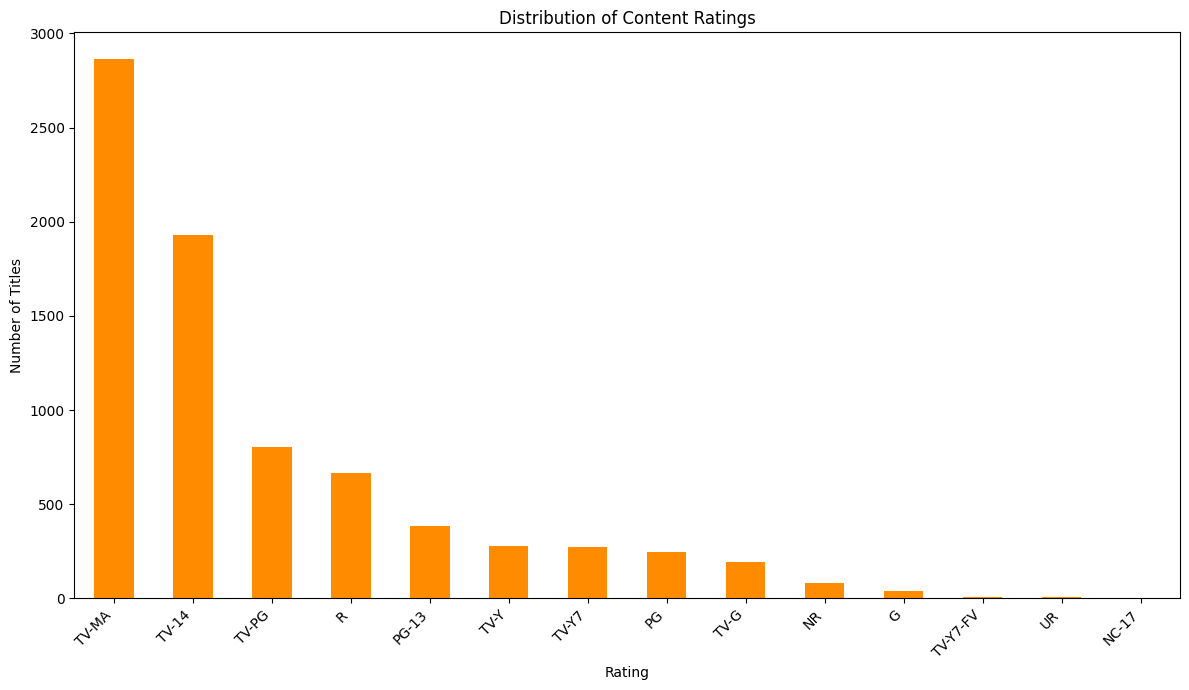

In [9]:
plt.figure(figsize=(12, 7))
df['rating'].value_counts().plot(kind='bar', color='darkorange')
plt.title('Distribution of Content Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

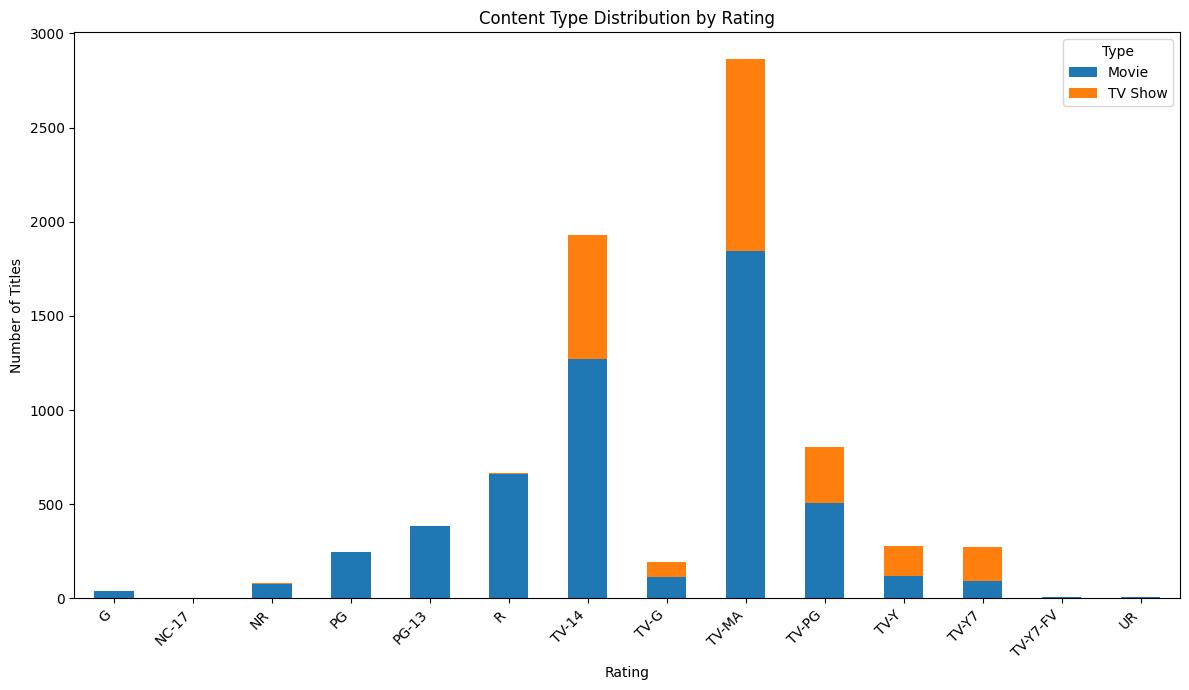

In [10]:
#Content Distribution Visualization
pd.crosstab(df['rating'], df['type']).plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Content Type Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

#Text Preprocessing

In [11]:
#This will be the unified textual representation.
def clean(x):
    if pd.isna(x):
        return ""
    return str(x).lower()

text_cols = ['title', 'director', 'cast', 'listed_in', 'description']

df[text_cols] = df[text_cols].fillna('')

df['content'] = (
      df['title'].apply(clean) + " " +
      df['description'].apply(clean) + " " +
      df['listed_in'].apply(clean) + " " +
      df['cast'].apply(clean) + " " +
      df['director'].apply(clean)+ " "
)

##A) TF-IDF + KMeans

In [12]:
# This is NLP Preprossing, which handles cleaning, normalization, vectorization
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,
    min_df=5,
    max_features=10000,
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(df['content'])

In [13]:
#We cannot use PCA on this Sparse Matrix, so we will be using TurcatedSVD.

svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(X)

k=5: Silhouette Score = 0.032
k=10: Silhouette Score = 0.041
k=15: Silhouette Score = 0.062
k=20: Silhouette Score = 0.070
k=25: Silhouette Score = 0.072
k=30: Silhouette Score = 0.074


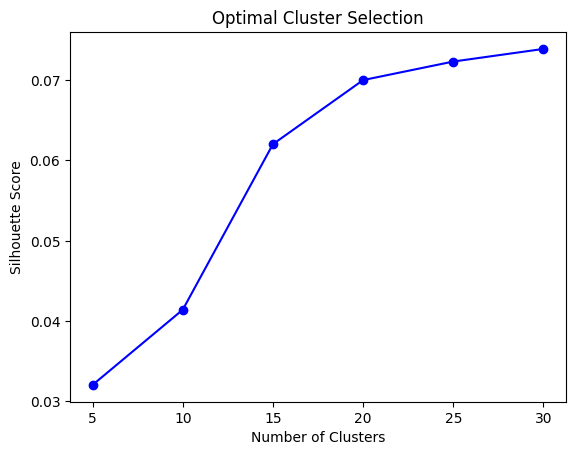


Optimal number of clusters: 30


In [52]:
#KMeans Clustering- Unsupervised Learning

silhouette_scores = []
K_range = range(5, 31, 5)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.3f}")

# Plot
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Selection')
plt.show()

# Choose optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
clusters = KMeans(n_clusters=optimal_k, random_state=42,n_init=10).fit_predict(X_reduced)
df['cluster'] = clusters
print(f"\nOptimal number of clusters: {optimal_k}")

In [53]:
print(silhouette_score(X_reduced, clusters))

0.07389353598404057


##B) HDBSCAN + Sentence Embeddings

In [ ]:
!pip install sentence-transformers hdbscan

In [25]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    df['content'].tolist(),
    show_progress_bar=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/244 [00:00<?, ?it/s]

In [26]:
Xn = normalize(embeddings)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    gen_min_span_tree=True
)

labels = clusterer.fit_predict(Xn)

print((labels != -1).mean())
clusterer.relative_validity_

0.34711698985488637


np.float64(3.0282771036015185e-05)

`
The attempt to use HDBSCAN has been unfruitful... So, I'll be researching graph based algorithms...
`



##C)Graph-based community detection (Leiden / Louvain) on a k-NN graph

> This is for research-purposes only...





In [41]:
!pip install igraph leidenalg pynndescent

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.8 MB/s eta 0:00:00


In [42]:
from pynndescent import NNDescent
import igraph as ig
import leidenalg

In [43]:
index = NNDescent(embeddings, n_neighbors=15, metric='cosine')
neighbors, distances = index.neighbor_graph

In [44]:
edges = []
n, k = neighbors.shape

for i in range(n):
    for j in neighbors[i]:
        if i != j:
            edges.append((i, int(j)))

g = ig.Graph(n=n, edges=edges, directed=False)

In [45]:
partition = leidenalg.find_partition(
    g,
    leidenalg.RBConfigurationVertexPartition,
    resolution_parameter=1.0
)

labels_leiden = np.array(partition.membership)

In [46]:
print(f"Silhouette Score: {silhouette_score(embeddings, labels_leiden)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(embeddings, labels_leiden)}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(embeddings, labels_leiden)}")

Silhouette Score: 0.024592652916908264
Davies-Bouldin Index: 4.954303554007834
Calinski-Harabasz Index: 83.35091400146484


##The Cluster Quality Metrics

The three scores (Silhouette, Davies-Bouldin, and Calinski-Harabasz) are commonly used metrics to evaluate the quality of clustering results, especially when the true labels of the data are unknown (unsupervised learning).

*   **Silhouette Score**: This metric measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to +1.
    *   A high value (close to +1) indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.
    *   A value around 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.
    *   Negative values indicate that those objects might have been assigned to the wrong cluster.

*   **Davies-Bouldin Index**: This index measures the average similarity ratio of each cluster with its most similar cluster, where similarity is defined as the ratio of within-cluster distances to between-cluster distances.
    *   A lower Davies-Bouldin index relates to a model with better separation between the clusters.
    *   The optimal score is 0.

*   **Calinski-Harabasz Index (Variance Ratio Criterion)**: This index is defined as the ratio of the sum of between-cluster dispersion and within-cluster dispersion.
    *   A higher Calinski-Harabasz index generally relates to a model with better-defined clusters.
    *   There is no 'optimal' value, but a higher score is better.


=== Model Comparison ===
  Model  Silhouette  Davies-Bouldin  Num Clusters
 KMeans    0.073894        2.791513            30
HDBSCAN   -0.012462        5.834165            30
 Leiden    0.024593        4.954304            12


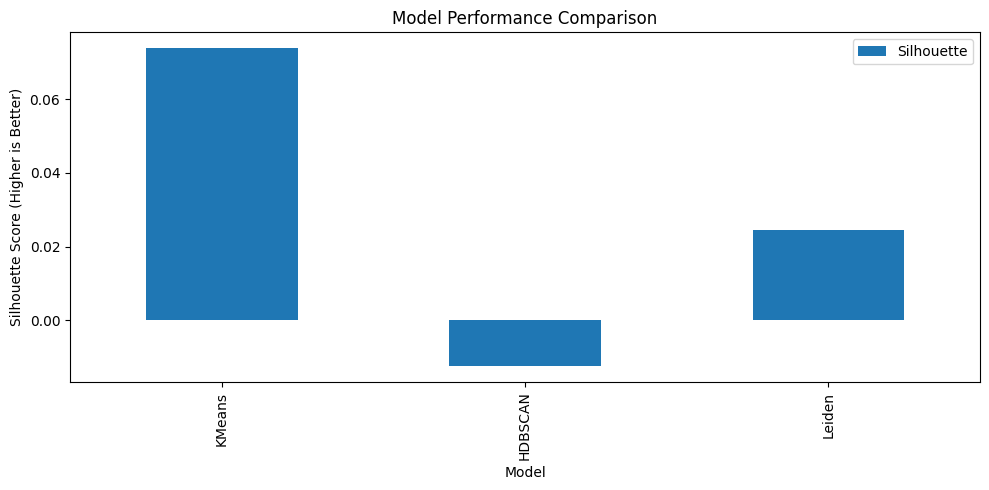

In [54]:
comparison = pd.DataFrame({
    'Model': ['KMeans', 'HDBSCAN', 'Leiden'],
    'Silhouette': [
        silhouette_score(X_reduced, clusters),
        silhouette_score(embeddings, labels) if (labels != -1).sum() > 10 else np.nan,
        silhouette_score(embeddings, labels_leiden)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_reduced, clusters),
        davies_bouldin_score(embeddings[labels!=-1], labels[labels!=-1]) if (labels != -1).sum() > 10 else np.nan,
        davies_bouldin_score(embeddings, labels_leiden)
    ],
    'Num Clusters': [
        30,
        len(set(labels)) - (1 if -1 in labels else 0),
        len(set(labels_leiden))
    ]
})

print("\n=== Model Comparison ===")
print(comparison.to_string(index=False))

# Visualize
comparison.set_index('Model')[['Silhouette']].plot(kind='bar', figsize=(10,5))
plt.title('Model Performance Comparison')
plt.ylabel('Silhouette Score (Higher is Better)')
plt.tight_layout()
plt.show()

#Recommender System

In [28]:
def recommend(title, df, vectors, top_n=7):

    idx = df[df['title'].str.lower() == title.lower()].index[0]

    sims = cosine_similarity(
        vectors[idx].reshape(1,-1),
        vectors
    )[0]

    sim_scores = list(enumerate(sims))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)

    sim_scores = sim_scores[1:top_n+1]

    indices = [i[0] for i in sim_scores]

    return df.iloc[indices][['title','type','listed_in']]

In [29]:
recommend("3 Idiots", df, X_reduced)

,title,type,listed_in
4872,PK,Movie,"Comedies, Dramas, International Movies"
1758,Dil Dhadakne Do,Movie,"Comedies, Dramas, International Movies"
1757,Dil Chahta Hai,Movie,"Comedies, Dramas, International Movies"
5097,Rang De Basanti,Movie,"Dramas, International Movies"
5624,Singapore,Movie,"Comedies, Dramas, International Movies"
4485,No Entry,Movie,"Comedies, International Movies"
7477,War Chhod Na Yaar,Movie,"Comedies, Dramas, International Movies"


In [37]:
def recommend_v2(title, df, embeddings, top_n=7):

    idx = df[df['title'].str.lower() == title.lower()].index[0]

    sims = cosine_similarity(
        embeddings[idx].reshape(1, -1),
        embeddings
    )[0]

    top_idx = np.argsort(sims)[::-1][1:top_n+1]

    return df.iloc[top_idx][['title','type','listed_in']]


In [38]:
recommend_v2("3 Idiots", df, embeddings)

,title,type,listed_in
2005,Engineering Girls,TV Show,"International TV Shows, TV Comedies"
4351,"My Schoolmate, the Barbarian",Movie,"Action & Adventure, Comedies, International Mo..."
2663,Hazaaron Khwaishein Aisi,Movie,"Dramas, International Movies, Romantic Movies"
3287,Kai Po Che!,Movie,"Dramas, International Movies, Sports Movies"
1473,Comedy High School,TV Show,"International TV Shows, TV Comedies"
6850,The School of Mischief,Movie,"Comedies, Dramas, International Movies"
1527,CRD,Movie,"Comedies, Dramas, Independent Movies"


In [32]:
def recommend_v3(title, df, vectors, top_n=7):
    """Improved recommendation with error handling."""
    # Check if title exists
    matching = df[df['title'].str.lower() == title.lower()]

    if matching.empty:
        # Find similar titles
        suggestions = get_close_matches(
            title.lower(),
            df['title'].str.lower().tolist(),
            n=5,
            cutoff=0.6
        )
        if suggestions:
            actual_titles = [df[df['title'].str.lower() == s].iloc[0]['title']
                           for s in suggestions]
            print(f"Title not found. Did you mean: {', '.join(actual_titles)}?")
        else:
            print(f"Title '{title}' not found.")
        return pd.DataFrame()

    idx = matching.index[0]
    sims = cosine_similarity(vectors[idx].reshape(1,-1), vectors)[0]
    top_idx = np.argsort(sims)[::-1][1:top_n+1]

    recs = df.iloc[top_idx][['title','type','listed_in','description']].copy()
    recs['similarity'] = sims[top_idx]

    return recs

In [39]:
recommend_v3("3 Idiots", df, X_reduced)

,title,type,listed_in,description,similarity
4872,PK,Movie,"Comedies, Dramas, International Movies",Aamir Khan teams with director Rajkumar Hirani...,0.724754
1758,Dil Dhadakne Do,Movie,"Comedies, Dramas, International Movies",While hosting a shipboard holiday for relative...,0.644624
1757,Dil Chahta Hai,Movie,"Comedies, Dramas, International Movies","Inseparable childhood friends Akash, Sameer an...",0.615225
5097,Rang De Basanti,Movie,"Dramas, International Movies",An idealistic English filmmaker casts a group ...,0.606492
5624,Singapore,Movie,"Comedies, Dramas, International Movies","When his employee disappears in Singapore, Shy...",0.595064
4485,No Entry,Movie,"Comedies, International Movies","After a prank goes sideways, three buddies fin...",0.593753
7477,War Chhod Na Yaar,Movie,"Comedies, Dramas, International Movies","Set in an India-Pakistan border post, this sat...",0.591042


#Interpretability for business stakeholders

In [ ]:
#We will map-back the centroid values to their orignal labels...
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
terms = vectorizer.get_feature_names_out()

for i in range(20):
    top = original_space_centroids[i].argsort()[-10:]
    print(f"Cluster {i}:")
    print([terms[j] for j in top])

Cluster 0:
['comedies', 'dramas international', 'love', 'comedies international', 'international', 'international movies', 'movies', 'romantic', 'movies romantic', 'romantic movies']
Cluster 1:
['talk', 'comic', 'states', 'united states', 'united', 'comedian', 'special', 'stand comedy', 'comedy', 'stand']
Cluster 2:
['independent movies', 'dramas independent', 'united states', 'states', 'united', 'dramas', 'movies', 'year old', 'year', 'old']
Cluster 3:
['rukh khan', 'shah rukh', 'dramas international', 'international', 'international movies', 'movies', 'shah', 'kapoor', 'india', 'khan']
Cluster 4:
['states', 'united states', 'international movies', 'united', 'dramas', 'movies international', 'movies', 'dramas independent', 'independent movies', 'independent']
Cluster 5:
['international tv', 'reality tv', 'reality', 'united kingdom', 'kingdom', 'british tv', 'british', 'shows', 'tv shows', 'tv']
Cluster 6:
['tv dramas', 'love', 'international tv', 'shows tv', 'romantic', 'shows romanti

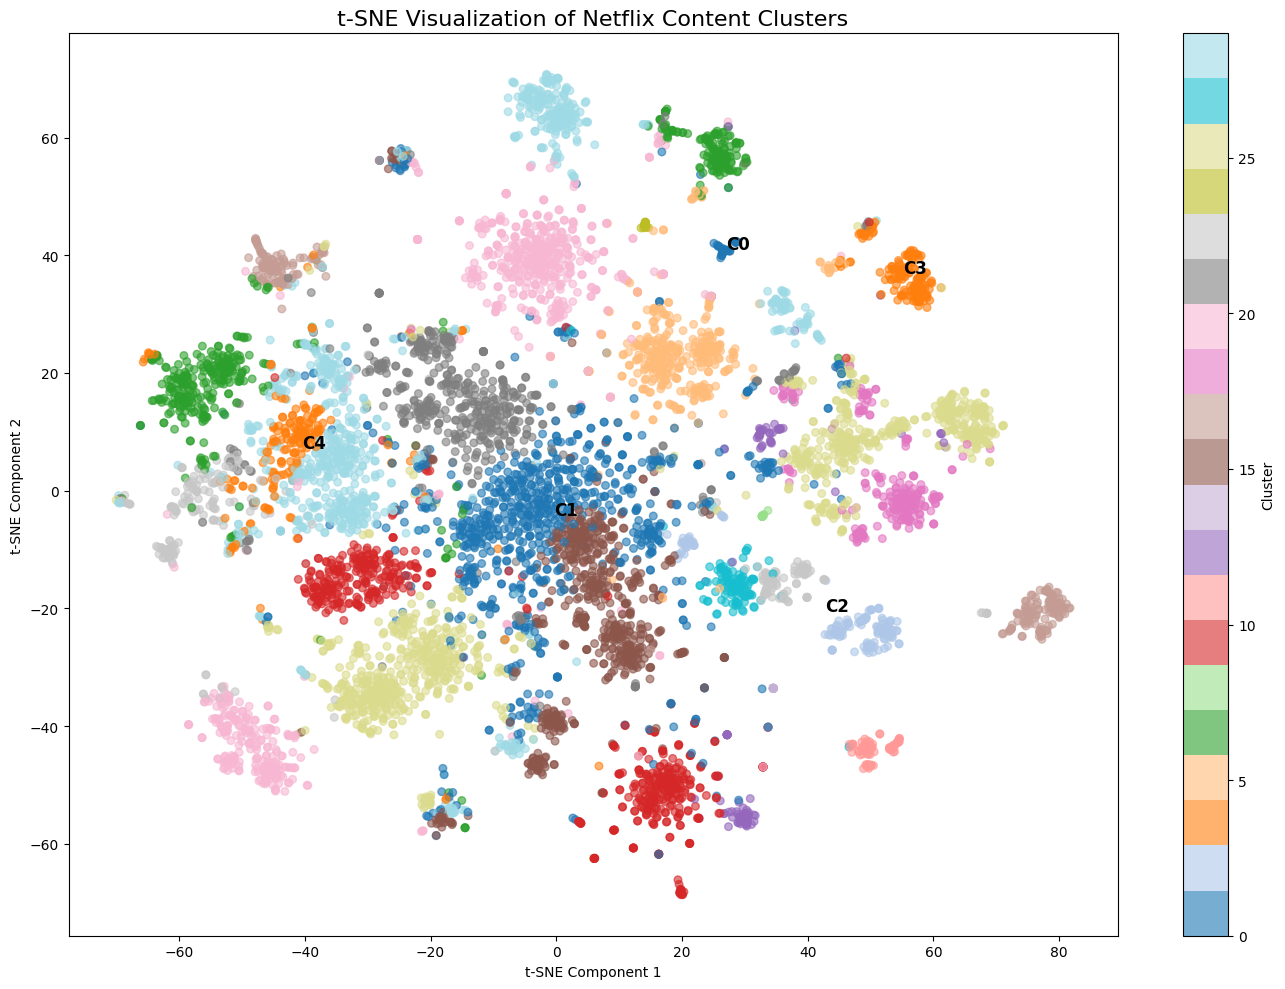

In [55]:
# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_reduced)

# Plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=df['cluster'],
    cmap='tab20',
    alpha=0.6,
    s=30
)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Netflix Content Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Annotate a few interesting points
for cluster_id in range(min(5, df['cluster'].nunique())):
    cluster_center = X_tsne[df['cluster'] == cluster_id].mean(axis=0)
    plt.annotate(
        f'C{cluster_id}',
        cluster_center,
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

In [59]:
# Show cluster characteristics
cluster_summary = df.groupby('cluster').agg({
    'type': lambda x: (x=='Movie').mean(),
    'release_year': 'mean',
    'rating': lambda x: x.mode()[0] if len(x)>0 else 'Unknown'
}).round(2)

print(cluster_summary)

         type  release_year rating
cluster                           
0        0.26       2008.42  TV-Y7
1        0.74       2012.39  TV-MA
2        0.00       2016.64  TV-MA
3        0.12       2016.76  TV-14
4        1.00       2013.35  TV-14
5        0.00       2015.91   TV-Y
6        0.21       2013.99  TV-14
7        1.00       2014.21  TV-14
8        0.67       2011.87  TV-MA
9        1.00       2015.46  TV-MA
10       1.00       2013.84  TV-MA
11       0.00       2016.49  TV-PG
12       0.14       2016.86  TV-MA
13       0.00       2016.00  TV-14
14       0.64       1995.21  TV-MA
15       0.99       2014.74  TV-MA
16       0.92       2007.65  TV-14
17       0.00       2016.92  TV-MA
18       0.00       2017.36  TV-MA
19       1.00       2013.37     PG
20       1.00       2012.93  TV-MA
21       0.96       2010.32  TV-MA
22       1.00       2005.89  TV-14
23       0.00       2017.84  TV-14
24       0.94       2013.75  TV-Y7
25       0.00       2015.94  TV-MA
26       1.00       

In [ ]:
#Taking out data for the local streamlit app.
df.to_pickle("df.pkl")
np.save("X_reduced.npy", X_reduced)
np.save("embeddings.npy", embeddings)

#Streamlit App(Test Run with NGROK)

### Step 1: Install Streamlit and pyngrok

In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
import streamlit as st

title = st.selectbox("Choose a title", df['title'].values)

if st.button("Recommend"):
    recs = recommend(title, df, X_reduced)
    st.write(recs)

2026-02-04 15:57:54.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-04 15:57:54.645 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

### Step 2: Authenticate ngrok (replace `YOUR_NGROK_AUTH_TOKEN` with your actual token)

In [ ]:
from pyngrok import ngrok
from google.colab import userdata

# Get your ngrok authentication token from ngrok.com/dashboard
ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN') # if stored in secrets

ngrok.set_auth_token(ngrok_auth_token)
print("ngrok authenticated.")

ngrok authenticated.


### Step 3: Create your Streamlit app file (`app.py`)

In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np

st.title('My First Streamlit App in Colab')

title = st.selectbox("Choose a title", df['title'].values)

if st.button("Recommend"):
    recs = recommend(title, df, X_reduced)
    st.write(recs)

Writing app.py


### Step 4: Run the Streamlit app and expose it via ngrok

In [ ]:
from pyngrok import ngrok

# Start a ngrok tunnel to the Streamlit app running on port 8501 (default Streamlit port)
public_url = ngrok.connect(addr='8501')
print(f"Your Streamlit app is live at: {public_url}")

# Run the Streamlit app (this will block the cell until you stop it or Colab disconnects)
!streamlit run app.py &>/dev/null

Your Streamlit app is live at: NgrokTunnel: "https://galileo-electrothermal-tally.ngrok-free.dev" -> "http://localhost:8501"
